## Dependencies

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from models import tiramisu
from datasets import deepglobe
from datasets import joint_transforms
import utils.imgs
import utils.training as train_utils

# tensorboard
from torch.utils.tensorboard import SummaryWriter

## CamVid

Clone this repository which holds the CamVid dataset
```
git clone https://github.com/alexgkendall/SegNet-Tutorial
```
No. Place deepglobe dataset in datasets/deepglobe/dataset/train,test,valid

In [2]:
CAMVID_PATH = Path('datasets/', 'deepglobe/dataset')
RESULTS_PATH = Path('.results/')
WEIGHTS_PATH = Path('.weights/')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)
batch_size = 1

In [3]:
# resize = joint_transforms.JointRandomCrop((360, 480))
# resize = joint_transforms.JointRandomCrop((300, 300))
# resize = joint_transforms.JointRandomCrop((512, 512))
# resize = joint_transforms.JointRandomCrop((1024, 1024))

# TODO: What if I train on a smaller random crop and fine-tune with 1024?

normalize = transforms.Normalize(mean=deepglobe.mean, std=deepglobe.std)
train_joint_transformer = transforms.Compose([
#     resize,
    joint_transforms.JointRandomHorizontalFlip(),
    joint_transforms.JointRandomVerticalFlip(),
    joint_transforms.JointRandomRotate()
    ])

train_slice = slice(None,4000)
test_slice = slice(4000,None)

train_dset = deepglobe.CamVid(CAMVID_PATH, 'train', slc = train_slice,
      joint_transform=train_joint_transformer,
      transform=transforms.Compose([
          transforms.ColorJitter(brightness=.4,contrast=.4,saturation=.4),
          transforms.ToTensor(),
          normalize,
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dset, batch_size=batch_size, shuffle=True)

# resize_joint_transformer = transforms.Compose([
#     resize
#     ])
resize_joint_transformer = None
val_dset = deepglobe.CamVid(
    CAMVID_PATH, 'valid', joint_transform=resize_joint_transformer,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
val_loader = torch.utils.data.DataLoader(
    val_dset, batch_size=batch_size, shuffle=False)

test_dset = deepglobe.CamVid(
    CAMVID_PATH, 'train', joint_transform=resize_joint_transformer, slc = test_slice,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
test_loader = torch.utils.data.DataLoader(
    test_dset, batch_size=batch_size, shuffle=False)

Train: 4000
Val: 1243
Test: 2226
Classes: 1
Inputs:  torch.Size([1, 3, 1024, 1024])
Targets:  torch.Size([1, 1024, 1024])


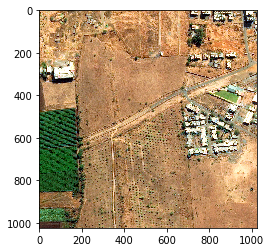

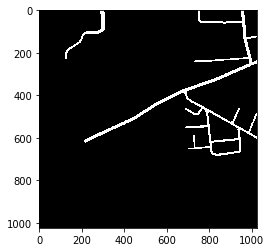

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)


In [4]:
print("Train: %d" %len(train_loader.dataset.imgs))
print("Val: %d" %len(val_loader.dataset.imgs))
print("Test: %d" %len(test_loader.dataset.imgs))
print("Classes: %d" % len(train_loader.dataset.classes))

print((iter(train_loader)))

inputs, targets = next(iter(train_loader))
print("Inputs: ", inputs.size())
print("Targets: ", targets.size())

utils.imgs.view_image(inputs[0])
# utils.imgs.view_image(targets[0])
utils.imgs.view_annotated(targets[0])

print(targets[0])

## Train

In [5]:
LR = 1e-4
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 1000
torch.cuda.manual_seed(0)

In [6]:
from utils.bceloss import dice_bce_loss

# model = tiramisu.FCDenseNet67(n_classes=2).cuda()
model = tiramisu.FCDenseNetSmall(n_classes=1).cuda()
model.apply(train_utils.weights_init)
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)
# criterion = nn.NLLLoss2d(weight=deepglobe.class_weight.cuda()).cuda()
# criterion = nn.NLLLoss().cuda() ##
criterion = dice_bce_loss()

# criterion = nn.NLLLoss2d(reduce=False).cuda()
# criterion = nn.CrossEntropyLoss().cuda()
# criterion = nn.NLLLoss2d().cuda()
# criterion = dice_bce_loss()
# criterion = nn.BCELoss().cuda()

/opt/colab/100layer_example/utils/training.py:167: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(m.weight)


In [7]:
start_epoch = 0
start_epoch = train_utils.load_weights(model, (train_utils.WEIGHTS_PATH+'latest.th'))
print(start_epoch)

loading weights '.weights/latest.th'
loaded weights (lastEpoch 274, loss 0.4753290773800307, error 0.5002677409968563)
275


In [8]:
# # Writer will output to ./runs/ directory by default
# run = "26"
# writer = SummaryWriter(log_dir=("./.runs/run" + str(run) + "/"))

In [9]:
#test_loader.dataset[0]

In [65]:
from utils import imgs as img_utils


OUT_PATH = Path('datasets/', 'deepglobe/out/run26')


from PIL import Image
import os


# predictions = train_utils.predict_validation(model, val_loader)

for pred in predictions:
#     print(predictions[1])

    im = transforms.ToPILImage()(pred[1]*255).convert("RGB")
    print(pred[2][0])
    path = os.path.join(OUT_PATH,os.path.split(pred[2][0])[1])
    print(path)
    im.save(path,"PNG")
    
_pred = predictions[0]

# img_utils.view_image(_pred[1])

# print(im)

# plt.imshow(im)
# plt.show()

datasets/deepglobe/dataset/valid/100794_sat.jpg
datasets/deepglobe/out/run26/100794_sat.jpg
datasets/deepglobe/dataset/valid/100905_sat.jpg
datasets/deepglobe/out/run26/100905_sat.jpg
datasets/deepglobe/dataset/valid/102867_sat.jpg
datasets/deepglobe/out/run26/102867_sat.jpg
datasets/deepglobe/dataset/valid/10417_sat.jpg
datasets/deepglobe/out/run26/10417_sat.jpg
datasets/deepglobe/dataset/valid/106553_sat.jpg
datasets/deepglobe/out/run26/106553_sat.jpg
datasets/deepglobe/dataset/valid/10678_sat.jpg
datasets/deepglobe/out/run26/10678_sat.jpg
datasets/deepglobe/dataset/valid/107243_sat.jpg
datasets/deepglobe/out/run26/107243_sat.jpg
datasets/deepglobe/dataset/valid/109245_sat.jpg
datasets/deepglobe/out/run26/109245_sat.jpg
datasets/deepglobe/dataset/valid/11053_sat.jpg
datasets/deepglobe/out/run26/11053_sat.jpg
datasets/deepglobe/dataset/valid/112600_sat.jpg
datasets/deepglobe/out/run26/112600_sat.jpg
datasets/deepglobe/dataset/valid/113081_sat.jpg
datasets/deepglobe/out/run26/113081_sa

datasets/deepglobe/dataset/valid/162232_sat.jpg
datasets/deepglobe/out/run26/162232_sat.jpg
datasets/deepglobe/dataset/valid/162586_sat.jpg
datasets/deepglobe/out/run26/162586_sat.jpg
datasets/deepglobe/dataset/valid/164671_sat.jpg
datasets/deepglobe/out/run26/164671_sat.jpg
datasets/deepglobe/dataset/valid/164758_sat.jpg
datasets/deepglobe/out/run26/164758_sat.jpg
datasets/deepglobe/dataset/valid/164777_sat.jpg
datasets/deepglobe/out/run26/164777_sat.jpg
datasets/deepglobe/dataset/valid/16480_sat.jpg
datasets/deepglobe/out/run26/16480_sat.jpg
datasets/deepglobe/dataset/valid/16521_sat.jpg
datasets/deepglobe/out/run26/16521_sat.jpg
datasets/deepglobe/dataset/valid/166094_sat.jpg
datasets/deepglobe/out/run26/166094_sat.jpg
datasets/deepglobe/dataset/valid/16642_sat.jpg
datasets/deepglobe/out/run26/16642_sat.jpg
datasets/deepglobe/dataset/valid/166681_sat.jpg
datasets/deepglobe/out/run26/166681_sat.jpg
datasets/deepglobe/dataset/valid/166785_sat.jpg
datasets/deepglobe/out/run26/166785_sa

datasets/deepglobe/dataset/valid/229233_sat.jpg
datasets/deepglobe/out/run26/229233_sat.jpg
datasets/deepglobe/dataset/valid/229386_sat.jpg
datasets/deepglobe/out/run26/229386_sat.jpg
datasets/deepglobe/dataset/valid/229545_sat.jpg
datasets/deepglobe/out/run26/229545_sat.jpg
datasets/deepglobe/dataset/valid/230195_sat.jpg
datasets/deepglobe/out/run26/230195_sat.jpg
datasets/deepglobe/dataset/valid/230212_sat.jpg
datasets/deepglobe/out/run26/230212_sat.jpg
datasets/deepglobe/dataset/valid/230262_sat.jpg
datasets/deepglobe/out/run26/230262_sat.jpg
datasets/deepglobe/dataset/valid/231554_sat.jpg
datasets/deepglobe/out/run26/231554_sat.jpg
datasets/deepglobe/dataset/valid/231579_sat.jpg
datasets/deepglobe/out/run26/231579_sat.jpg
datasets/deepglobe/dataset/valid/232370_sat.jpg
datasets/deepglobe/out/run26/232370_sat.jpg
datasets/deepglobe/dataset/valid/232835_sat.jpg
datasets/deepglobe/out/run26/232835_sat.jpg
datasets/deepglobe/dataset/valid/233182_sat.jpg
datasets/deepglobe/out/run26/233

datasets/deepglobe/dataset/valid/288219_sat.jpg
datasets/deepglobe/out/run26/288219_sat.jpg
datasets/deepglobe/dataset/valid/288366_sat.jpg
datasets/deepglobe/out/run26/288366_sat.jpg
datasets/deepglobe/dataset/valid/289761_sat.jpg
datasets/deepglobe/out/run26/289761_sat.jpg
datasets/deepglobe/dataset/valid/290434_sat.jpg
datasets/deepglobe/out/run26/290434_sat.jpg
datasets/deepglobe/dataset/valid/290555_sat.jpg
datasets/deepglobe/out/run26/290555_sat.jpg
datasets/deepglobe/dataset/valid/290824_sat.jpg
datasets/deepglobe/out/run26/290824_sat.jpg
datasets/deepglobe/dataset/valid/291421_sat.jpg
datasets/deepglobe/out/run26/291421_sat.jpg
datasets/deepglobe/dataset/valid/291501_sat.jpg
datasets/deepglobe/out/run26/291501_sat.jpg
datasets/deepglobe/dataset/valid/293020_sat.jpg
datasets/deepglobe/out/run26/293020_sat.jpg
datasets/deepglobe/dataset/valid/293468_sat.jpg
datasets/deepglobe/out/run26/293468_sat.jpg
datasets/deepglobe/dataset/valid/293724_sat.jpg
datasets/deepglobe/out/run26/293

datasets/deepglobe/dataset/valid/351236_sat.jpg
datasets/deepglobe/out/run26/351236_sat.jpg
datasets/deepglobe/dataset/valid/353819_sat.jpg
datasets/deepglobe/out/run26/353819_sat.jpg
datasets/deepglobe/dataset/valid/354676_sat.jpg
datasets/deepglobe/out/run26/354676_sat.jpg
datasets/deepglobe/dataset/valid/35481_sat.jpg
datasets/deepglobe/out/run26/35481_sat.jpg
datasets/deepglobe/dataset/valid/354978_sat.jpg
datasets/deepglobe/out/run26/354978_sat.jpg
datasets/deepglobe/dataset/valid/355593_sat.jpg
datasets/deepglobe/out/run26/355593_sat.jpg
datasets/deepglobe/dataset/valid/35643_sat.jpg
datasets/deepglobe/out/run26/35643_sat.jpg
datasets/deepglobe/dataset/valid/356636_sat.jpg
datasets/deepglobe/out/run26/356636_sat.jpg
datasets/deepglobe/dataset/valid/357034_sat.jpg
datasets/deepglobe/out/run26/357034_sat.jpg
datasets/deepglobe/dataset/valid/359003_sat.jpg
datasets/deepglobe/out/run26/359003_sat.jpg
datasets/deepglobe/dataset/valid/359030_sat.jpg
datasets/deepglobe/out/run26/359030_

datasets/deepglobe/dataset/valid/413884_sat.jpg
datasets/deepglobe/out/run26/413884_sat.jpg
datasets/deepglobe/dataset/valid/413892_sat.jpg
datasets/deepglobe/out/run26/413892_sat.jpg
datasets/deepglobe/dataset/valid/414019_sat.jpg
datasets/deepglobe/out/run26/414019_sat.jpg
datasets/deepglobe/dataset/valid/416535_sat.jpg
datasets/deepglobe/out/run26/416535_sat.jpg
datasets/deepglobe/dataset/valid/41689_sat.jpg
datasets/deepglobe/out/run26/41689_sat.jpg
datasets/deepglobe/dataset/valid/417891_sat.jpg
datasets/deepglobe/out/run26/417891_sat.jpg
datasets/deepglobe/dataset/valid/418867_sat.jpg
datasets/deepglobe/out/run26/418867_sat.jpg
datasets/deepglobe/dataset/valid/424647_sat.jpg
datasets/deepglobe/out/run26/424647_sat.jpg
datasets/deepglobe/dataset/valid/42570_sat.jpg
datasets/deepglobe/out/run26/42570_sat.jpg
datasets/deepglobe/dataset/valid/426659_sat.jpg
datasets/deepglobe/out/run26/426659_sat.jpg
datasets/deepglobe/dataset/valid/426698_sat.jpg
datasets/deepglobe/out/run26/426698_

datasets/deepglobe/dataset/valid/486476_sat.jpg
datasets/deepglobe/out/run26/486476_sat.jpg
datasets/deepglobe/dataset/valid/487250_sat.jpg
datasets/deepglobe/out/run26/487250_sat.jpg
datasets/deepglobe/dataset/valid/487709_sat.jpg
datasets/deepglobe/out/run26/487709_sat.jpg
datasets/deepglobe/dataset/valid/487995_sat.jpg
datasets/deepglobe/out/run26/487995_sat.jpg
datasets/deepglobe/dataset/valid/489768_sat.jpg
datasets/deepglobe/out/run26/489768_sat.jpg
datasets/deepglobe/dataset/valid/49049_sat.jpg
datasets/deepglobe/out/run26/49049_sat.jpg
datasets/deepglobe/dataset/valid/491593_sat.jpg
datasets/deepglobe/out/run26/491593_sat.jpg
datasets/deepglobe/dataset/valid/492267_sat.jpg
datasets/deepglobe/out/run26/492267_sat.jpg
datasets/deepglobe/dataset/valid/492364_sat.jpg
datasets/deepglobe/out/run26/492364_sat.jpg
datasets/deepglobe/dataset/valid/492570_sat.jpg
datasets/deepglobe/out/run26/492570_sat.jpg
datasets/deepglobe/dataset/valid/492799_sat.jpg
datasets/deepglobe/out/run26/49279

datasets/deepglobe/dataset/valid/54561_sat.jpg
datasets/deepglobe/out/run26/54561_sat.jpg
datasets/deepglobe/dataset/valid/546642_sat.jpg
datasets/deepglobe/out/run26/546642_sat.jpg
datasets/deepglobe/dataset/valid/546813_sat.jpg
datasets/deepglobe/out/run26/546813_sat.jpg
datasets/deepglobe/dataset/valid/54778_sat.jpg
datasets/deepglobe/out/run26/54778_sat.jpg
datasets/deepglobe/dataset/valid/551217_sat.jpg
datasets/deepglobe/out/run26/551217_sat.jpg
datasets/deepglobe/dataset/valid/551632_sat.jpg
datasets/deepglobe/out/run26/551632_sat.jpg
datasets/deepglobe/dataset/valid/551638_sat.jpg
datasets/deepglobe/out/run26/551638_sat.jpg
datasets/deepglobe/dataset/valid/551868_sat.jpg
datasets/deepglobe/out/run26/551868_sat.jpg
datasets/deepglobe/dataset/valid/552415_sat.jpg
datasets/deepglobe/out/run26/552415_sat.jpg
datasets/deepglobe/dataset/valid/55336_sat.jpg
datasets/deepglobe/out/run26/55336_sat.jpg
datasets/deepglobe/dataset/valid/553414_sat.jpg
datasets/deepglobe/out/run26/553414_sa

datasets/deepglobe/dataset/valid/622836_sat.jpg
datasets/deepglobe/out/run26/622836_sat.jpg
datasets/deepglobe/dataset/valid/625418_sat.jpg
datasets/deepglobe/out/run26/625418_sat.jpg
datasets/deepglobe/dataset/valid/626983_sat.jpg
datasets/deepglobe/out/run26/626983_sat.jpg
datasets/deepglobe/dataset/valid/627061_sat.jpg
datasets/deepglobe/out/run26/627061_sat.jpg
datasets/deepglobe/dataset/valid/628187_sat.jpg
datasets/deepglobe/out/run26/628187_sat.jpg
datasets/deepglobe/dataset/valid/63020_sat.jpg
datasets/deepglobe/out/run26/63020_sat.jpg
datasets/deepglobe/dataset/valid/630270_sat.jpg
datasets/deepglobe/out/run26/630270_sat.jpg
datasets/deepglobe/dataset/valid/630608_sat.jpg
datasets/deepglobe/out/run26/630608_sat.jpg
datasets/deepglobe/dataset/valid/633138_sat.jpg
datasets/deepglobe/out/run26/633138_sat.jpg
datasets/deepglobe/dataset/valid/634892_sat.jpg
datasets/deepglobe/out/run26/634892_sat.jpg
datasets/deepglobe/dataset/valid/635232_sat.jpg
datasets/deepglobe/out/run26/63523

datasets/deepglobe/dataset/valid/695071_sat.jpg
datasets/deepglobe/out/run26/695071_sat.jpg
datasets/deepglobe/dataset/valid/695852_sat.jpg
datasets/deepglobe/out/run26/695852_sat.jpg
datasets/deepglobe/dataset/valid/6961_sat.jpg
datasets/deepglobe/out/run26/6961_sat.jpg
datasets/deepglobe/dataset/valid/696659_sat.jpg
datasets/deepglobe/out/run26/696659_sat.jpg
datasets/deepglobe/dataset/valid/698255_sat.jpg
datasets/deepglobe/out/run26/698255_sat.jpg
datasets/deepglobe/dataset/valid/698657_sat.jpg
datasets/deepglobe/out/run26/698657_sat.jpg
datasets/deepglobe/dataset/valid/698979_sat.jpg
datasets/deepglobe/out/run26/698979_sat.jpg
datasets/deepglobe/dataset/valid/699348_sat.jpg
datasets/deepglobe/out/run26/699348_sat.jpg
datasets/deepglobe/dataset/valid/700588_sat.jpg
datasets/deepglobe/out/run26/700588_sat.jpg
datasets/deepglobe/dataset/valid/70067_sat.jpg
datasets/deepglobe/out/run26/70067_sat.jpg
datasets/deepglobe/dataset/valid/701441_sat.jpg
datasets/deepglobe/out/run26/701441_sa

datasets/deepglobe/dataset/valid/769148_sat.jpg
datasets/deepglobe/out/run26/769148_sat.jpg
datasets/deepglobe/dataset/valid/772455_sat.jpg
datasets/deepglobe/out/run26/772455_sat.jpg
datasets/deepglobe/dataset/valid/772467_sat.jpg
datasets/deepglobe/out/run26/772467_sat.jpg
datasets/deepglobe/dataset/valid/773412_sat.jpg
datasets/deepglobe/out/run26/773412_sat.jpg
datasets/deepglobe/dataset/valid/773550_sat.jpg
datasets/deepglobe/out/run26/773550_sat.jpg
datasets/deepglobe/dataset/valid/774048_sat.jpg
datasets/deepglobe/out/run26/774048_sat.jpg
datasets/deepglobe/dataset/valid/774543_sat.jpg
datasets/deepglobe/out/run26/774543_sat.jpg
datasets/deepglobe/dataset/valid/775230_sat.jpg
datasets/deepglobe/out/run26/775230_sat.jpg
datasets/deepglobe/dataset/valid/775385_sat.jpg
datasets/deepglobe/out/run26/775385_sat.jpg
datasets/deepglobe/dataset/valid/775659_sat.jpg
datasets/deepglobe/out/run26/775659_sat.jpg
datasets/deepglobe/dataset/valid/775911_sat.jpg
datasets/deepglobe/out/run26/775

datasets/deepglobe/dataset/valid/830769_sat.jpg
datasets/deepglobe/out/run26/830769_sat.jpg
datasets/deepglobe/dataset/valid/831013_sat.jpg
datasets/deepglobe/out/run26/831013_sat.jpg
datasets/deepglobe/dataset/valid/832447_sat.jpg
datasets/deepglobe/out/run26/832447_sat.jpg
datasets/deepglobe/dataset/valid/832801_sat.jpg
datasets/deepglobe/out/run26/832801_sat.jpg
datasets/deepglobe/dataset/valid/833901_sat.jpg
datasets/deepglobe/out/run26/833901_sat.jpg
datasets/deepglobe/dataset/valid/834969_sat.jpg
datasets/deepglobe/out/run26/834969_sat.jpg
datasets/deepglobe/dataset/valid/836854_sat.jpg
datasets/deepglobe/out/run26/836854_sat.jpg
datasets/deepglobe/dataset/valid/837327_sat.jpg
datasets/deepglobe/out/run26/837327_sat.jpg
datasets/deepglobe/dataset/valid/837944_sat.jpg
datasets/deepglobe/out/run26/837944_sat.jpg
datasets/deepglobe/dataset/valid/841171_sat.jpg
datasets/deepglobe/out/run26/841171_sat.jpg
datasets/deepglobe/dataset/valid/841405_sat.jpg
datasets/deepglobe/out/run26/841

datasets/deepglobe/dataset/valid/910547_sat.jpg
datasets/deepglobe/out/run26/910547_sat.jpg
datasets/deepglobe/dataset/valid/910886_sat.jpg
datasets/deepglobe/out/run26/910886_sat.jpg
datasets/deepglobe/dataset/valid/912053_sat.jpg
datasets/deepglobe/out/run26/912053_sat.jpg
datasets/deepglobe/dataset/valid/912155_sat.jpg
datasets/deepglobe/out/run26/912155_sat.jpg
datasets/deepglobe/dataset/valid/912429_sat.jpg
datasets/deepglobe/out/run26/912429_sat.jpg
datasets/deepglobe/dataset/valid/912598_sat.jpg
datasets/deepglobe/out/run26/912598_sat.jpg
datasets/deepglobe/dataset/valid/912667_sat.jpg
datasets/deepglobe/out/run26/912667_sat.jpg
datasets/deepglobe/dataset/valid/913313_sat.jpg
datasets/deepglobe/out/run26/913313_sat.jpg
datasets/deepglobe/dataset/valid/913360_sat.jpg
datasets/deepglobe/out/run26/913360_sat.jpg
datasets/deepglobe/dataset/valid/913377_sat.jpg
datasets/deepglobe/out/run26/913377_sat.jpg
datasets/deepglobe/dataset/valid/913700_sat.jpg
datasets/deepglobe/out/run26/913

datasets/deepglobe/dataset/valid/976443_sat.jpg
datasets/deepglobe/out/run26/976443_sat.jpg
datasets/deepglobe/dataset/valid/979591_sat.jpg
datasets/deepglobe/out/run26/979591_sat.jpg
datasets/deepglobe/dataset/valid/979651_sat.jpg
datasets/deepglobe/out/run26/979651_sat.jpg
datasets/deepglobe/dataset/valid/979824_sat.jpg
datasets/deepglobe/out/run26/979824_sat.jpg
datasets/deepglobe/dataset/valid/981739_sat.jpg
datasets/deepglobe/out/run26/981739_sat.jpg
datasets/deepglobe/dataset/valid/981785_sat.jpg
datasets/deepglobe/out/run26/981785_sat.jpg
datasets/deepglobe/dataset/valid/9821_sat.jpg
datasets/deepglobe/out/run26/9821_sat.jpg
datasets/deepglobe/dataset/valid/982728_sat.jpg
datasets/deepglobe/out/run26/982728_sat.jpg
datasets/deepglobe/dataset/valid/983142_sat.jpg
datasets/deepglobe/out/run26/983142_sat.jpg
datasets/deepglobe/dataset/valid/983867_sat.jpg
datasets/deepglobe/out/run26/983867_sat.jpg
datasets/deepglobe/dataset/valid/983896_sat.jpg
datasets/deepglobe/out/run26/983896_

In [ ]:
break
from torch.autograd import Variable

# break # errors. Used to stop "run all"
for epoch in range(start_epoch, N_EPOCHS+1):
    since = time.time()

    ### Train ###
    trn_loss, trn_err = train_utils.train(
        model, train_loader, optimizer, criterion, epoch)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(
        epoch, trn_loss, 1-trn_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
#     ### Test ###
#     val_loss, val_err = train_utils.test(model, val_loader, criterion, epoch)    
#     print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss, 1-val_err))
#     time_elapsed = time.time() - since  
#     print('Total Time {:.0f}m {:.0f}s\n'.format(
#         time_elapsed // 60, time_elapsed % 60))
#     val_loss = trn_loss
#     val_err = trn_err
    ### Test ###
    tes_loss, tes_err, tes_iou = train_utils.test(model, test_loader, criterion, epoch)    
    print('Tes - Loss: {:.4f} | Acc: {:.4f}'.format(tes_loss, 1-tes_err))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    
#     val_loss = trn_loss
#     val_err = trn_err
    
    ### Checkpoint ###    
    train_utils.save_weights(model, epoch, tes_loss, tes_err)

    ### Adjust Lr ###
#     train_utils.adjust_learning_rate(LR, LR_DECAY, optimizer, 
#                                      epoch, DECAY_EVERY_N_EPOCHS)
    
    # Log on tensorboard
    writer.add_scalar('Loss/train', trn_loss, epoch)
    writer.add_scalar('Loss/test', tes_loss, epoch)
    
    writer.add_scalar('Error/train', trn_err, epoch)
    writer.add_scalar('Error/test', tes_err, epoch)
    
#     writer.add_scalar('Accuracy/train', trn_iou, epoch)
    writer.add_scalar('Accuracy/test', tes_iou, epoch)
    
#     writer.add_scalar('Accuracy/train', epoch_acc, epoch)
#     writer.add_scalar('Accuracy/test/noaug', do_valid(False), epoch)
#     writer.add_scalar('Accuracy/test/tta', do_valid(True), epoch)
    for param_group in optimizer.param_groups:
        writer.add_scalar('Params/learning_rage', param_group['lr'], epoch)
#     writer.add_scalar('params/learning_rate', optimizer.lr, epoch)
#     writer.add_scalar('Params/no_optim', no_optim, epoch)

    # show a sample image
    for i in range(3):
        inputs, targets, pred, loss, err, iou = train_utils.get_sample_predictions(model, test_loader, n=1, criterion=criterion)
#         print(inputs.shape)
        raw = model(inputs.cuda()).cpu()
#         print(raw.shape)
#         print(pred.shape)

# #         img = pred
        
# #         img = torchvision.utils.make_grid([inputs, targets, pred], nrow=8, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)
        
# #         img = torchvision.utils.make_grid(torch.stack([inputs[0], targets[0], pred[0].float().float()]))
# #         print(inputs.shape)
# #         print(targets.shape)
# #         print(pred.shape)
        
#         # print stats on raw
#         print("max", raw.max())
#         print("min", raw.min())
        
        
        img = torchvision.utils.make_grid(torch.stack([
            inputs[0],
            targets[0].unsqueeze(0).expand(3,-1,-1).float(), 
            pred[0].unsqueeze(0).expand(3,-1,-1).float(),
            raw[0].expand(3,-1,-1).float()
        ]), normalize=True)
        

        writer.add_image('test/sample_pred', img, epoch)
        break
    
    start_epoch = epoch
    


## Test

In [ ]:
# returns test_loss, test_error, jaccard
train_utils.test(model, test_loader, criterion, epoch=1)  

In [ ]:
train_utils.test(model, test_loader, criterion, epoch=1, use_tta=True)  # flip tta

In [ ]:
train_utils.test(model, test_loader, criterion, epoch=1, use_tta=True)  # rot tta

In [ ]:
stats = train_utils.view_sample_predictions(model, test_loader, n=1, criterion=criterion)
print("loss", "error", "jaccard")
print(stats)
